# Predicting Pharmaceutical Product Prices for KEMSA Supply Chain (Forecasting 2025 Prices Using 2017 Data)


## 1. Data Collection & Understanding
- I am using KEMSA 2017 CSV file from African Data Catalogue(https://open.africa/dataset/kemsa-price-list) - It may not be accurately updated but will work for this simulation.
- ##### KEMSA Price List
Kenya Medical Supplies Authority (KEMSA)'s recommended prices for medical supplies prescribed in essential health packages and national referral hospitals.
Source	http://www.kemsa.co.ke/salespricelist/

In [51]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# 2. Load Data
df = pd.read_csv("kemsa_pricelist_2017.csv") 
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (549, 9)


,Item Type,Product Code,Product Name,Product Category,Pack Size,Price,Qty To Order,Notes,Value of Order
0,Pharmaceutical,PM05ASA001,Acetylsalicylic acid Tablets 300mg,TABLETS AND CAPSULES,1000s,265.00,0.0,NaN,0.0
1,Pharmaceutical,PM05ASA002,Acetylsalicylic acid Tablets 75mg-enteric coated,TABLETS AND CAPSULES,28s,45.00,0.0,NaN,0.0
2,Pharmaceutical,PM04ACY001,Acyclovir Tablets 400mg,TABLETS AND CAPSULES,100s,700.00,0.0,NaN,0.0
3,Pharmaceutical,PM03ALB003,Albendazole Tablets 400mg,TABLETS AND CAPSULES,500s,"1,300.00",0.0,NaN,0.0
4,Pharmaceutical,PM07AMT001,Amitriptyline Tablets 25mg,TABLETS AND CAPSULES,1000s,405.00,0.0,NaN,0.0


## 2. Data Cleaning & Preprocessing

In [52]:
# 3. Data Exploration
df.info()
print(df.describe(include='all'))
print(df['Product Category'].value_counts())
print(df['Pack Size'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Item Type         549 non-null    object 
 1   Product Code      549 non-null    object 
 2   Product Name      549 non-null    object 
 3   Product Category  549 non-null    object 
 4   Pack Size         548 non-null    object 
 5    Price            530 non-null    object 
 6   Qty To Order      547 non-null    float64
 7   Notes             134 non-null    object 
 8   Value of Order    531 non-null    float64
dtypes: float64(2), object(7)
memory usage: 38.7+ KB
                   Item Type Product Code                   Product Name  \
count                    549          549                            549   
unique                     8          548                            544   
top     Non - Pharmaceutical   NU02STA032  Clarithromycin  Tablets 500mg   
freq                  

In [53]:
# 4. Data Cleaning
# Drop irrelevant columns if present
df = df.drop(columns=['Notes', 'Qty To Order', 'Value of Order'], errors='ignore')

# Clean Price column: remove commas and convert to float
df[' Price'] = df[' Price'].replace(',', '', regex=True).astype(float)

# Drop rows with missing critical values
df = df.dropna(subset=[' Price', 'Product Code', 'Product Name', 'Product Category', 'Pack Size'])

df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Item Type         530 non-null    object 
 1   Product Code      530 non-null    object 
 2   Product Name      530 non-null    object 
 3   Product Category  530 non-null    object 
 4   Pack Size         530 non-null    object 
 5    Price            530 non-null    float64
dtypes: float64(1), object(5)
memory usage: 25.0+ KB


## 3.Feature Engineering & Exploratory Data Analysis

*Feature engineering* is the process of creating new input features or transforming existing ones to better represent the underlying problem to predictive models. Good features can significantly improve model accuracy, interpretability, and robustness.

### Why is Feature Engineering Important
- Enhances model learning: Raw data often contains information in formats that models cannot interpret directly (e.g., strings like "1000s" or product names).

- Extracts hidden patterns: By breaking down complex fields (like product names or pack sizes), you can capture important signals that affect price.

- Reduces noise: Cleaning and transforming features can reduce irrelevant or redundant information.

- Handles categorical data: Many ML algorithms require numeric inputs, so categorical data needs to be encoded appropriately.

In [54]:
# 5. Feature Engineering
import re

# Extract numeric pack size - *Numeric pack size quantifies the amount of product, which correlates with price*.
df['Pack Size Num'] = df['Pack Size'].str.extract(r'(\d+)').astype(float)

# Extract pack size unit - *Units like "s" (units), "ml" (milliliters), or "mg" (milligrams) indicate different packaging or dosage forms, influencing price.*
df['Pack Size Unit'] = df['Pack Size'].str.extract(r'([a-zA-Z]+)')

# Extract dosage (mg/ml) from product name -  *Dosage strength impacts the cost; higher dosages often mean higher prices.*
df['Dosage'] = df['Product Name'].str.extract(r'(\d+\.?\d*)\s*(mg|ml|mL|MG)', expand=True)[0].astype(float)

# Extract product form (tablet, syrup, etc.) - *Different forms have different manufacturing costs and pricing.*
df['Form'] = df['Product Name'].str.extract(r'(Tablet|Capsule|Syrup|Injection|Cream)', flags=re.IGNORECASE, expand=False).str.lower()

# One-hot encode categorical variables - *Machine learning models require numeric inputs; one-hot encoding converts categories into binary(numeric) features.*
df = pd.get_dummies(df, columns=['Product Category', 'Pack Size Unit', 'Form', 'Item Type'], drop_first=True)

df.head()


,Product Code,Product Name,Pack Size,Price,Pack Size Num,Dosage,Product Category_ Oral liquids,Product Category_ TABLETS AND CAPSULES,Product Category_ADMINISTRATION SETS,Product Category_Anti diarrheal,...,Form_cream,Form_injection,Form_syrup,Form_tablet,Item Type_Laboratory Commodities,Item Type_Linen Items,Item Type_Non - Pharmaceutical,Item Type_Pharmaceutical,Item Type_SSD - Pharmaceutical,Item Type_X-ray Items
0,PM05ASA001,Acetylsalicylic acid Tablets 300mg,1000s,265.0,1000.0,300.0,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
1,PM05ASA002,Acetylsalicylic acid Tablets 75mg-enteric coated,28s,45.0,28.0,75.0,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
2,PM04ACY001,Acyclovir Tablets 400mg,100s,700.0,100.0,400.0,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
3,PM03ALB003,Albendazole Tablets 400mg,500s,1300.0,500.0,400.0,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
4,PM07AMT001,Amitriptyline Tablets 25mg,1000s,405.0,1000.0,25.0,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False


In [55]:
feature_cols = [col for col in df.columns if col not in ['Price', 'Product Code', 'Product Name', 'Pack Size']]
X = df[feature_cols]


In [56]:
# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN with 0 (or another value)
X.fillna(0, inplace=True)

# Now convert to int safely
X = X.astype(int)


In [57]:
# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs with zero or median or mean as appropriate
X.fillna(0, inplace=True)

# Now convert boolean columns to int safely
X = X.astype(int)


In [58]:
X = X.dropna()  # Drops rows with any NaN
# or
X = X.dropna(axis=1)  # Drops columns with any NaN


In [59]:
# 1. Fix column names by stripping spaces
df.columns = df.columns.str.strip()

# 2. Define features and target with correct column names
feature_cols = [col for col in df.columns if col not in ['Price', 'Product Code', 'Product Name', 'Pack Size']]
X = df[feature_cols]
y = df['Price']

# 3. Check for missing values in X and fill or drop them
print("Missing values per column before filling:")
print(X.isnull().sum())

# Fill missing values with 0 (or choose a suitable strategy)
X = X.fillna(0)

# 4. Convert boolean columns to integers
bool_cols = X.select_dtypes(include=['bool']).columns
for col in bool_cols:
    X[col] = X[col].astype(int)

# 5. Now safely split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Missing values per column before filling:
Pack Size Num                             295
Dosage                                    328
Product Category_ Oral liquids              0
Product Category_ TABLETS AND CAPSULES      0
Product Category_ADMINISTRATION SETS        0
                                         ... 
Item Type_Linen Items                       0
Item Type_Non - Pharmaceutical              0
Item Type_Pharmaceutical                    0
Item Type_SSD - Pharmaceutical              0
Item Type_X-ray Items                       0
Length: 94, dtype: int64
Train samples: 424, Test samples: 106


In [60]:
X[bool_cols] = X[bool_cols].replace({True: 1, False: 0})


In [61]:
print(df.columns.tolist())
print(X.dtypes)


['Product Code', 'Product Name', 'Pack Size', 'Price', 'Pack Size Num', 'Dosage', 'Product Category_ Oral liquids', 'Product Category_ TABLETS AND CAPSULES', 'Product Category_ADMINISTRATION SETS', 'Product Category_Anti diarrheal', 'Product Category_Bag', 'Product Category_CANNULAS', 'Product Category_CATHETERS', 'Product Category_COUNTER', 'Product Category_DENTAL ITEMS', 'Product Category_DERMATOLOGICALS', 'Product Category_DISINFECTANTS $ ANTISEPTICS', 'Product Category_DISPENSING', 'Product Category_DISPOSAL BAGS', 'Product Category_DRAINAGE TUBES', 'Product Category_Diapers', 'Product Category_ENVIROMENTAL SUPPLIES', 'Product Category_INHALER', 'Product Category_INJECTIONS', 'Product Category_Injections', 'Product Category_LABELS', 'Product Category_LINEN', 'Product Category_LINEN ITEMS', 'Product Category_Lab devices & consumables', 'Product Category_MATERNITY SUPPLIES', 'Product Category_NARCOTIS', 'Product Category_OPTHALMOLOGICALS', 'Product Category_OPTHAMOLOGICAL LENSES', '

#### EDA

1. Price Distribution by Product Category (Boxplot)
Shows how prices vary across different product categories, highlighting median prices, spread, and outliers to identify which categories tend to be more expensive or variable.

2. Price vs. Pack Size Numeric (Scatterplot)
Visualizes the relationship between product quantity (pack size) and price, revealing trends or clusters that indicate how packaging size influences cost.

3. Price vs. Dosage (Scatterplot)
Illustrates how dosage strength correlates with price, helping to understand if higher dosages command higher prices.

4. Count of Products by Form (Bar Plot)
Displays the frequency of different pharmaceutical forms (e.g., tablets, syrups), providing insight into product composition and availability.

5. Correlation Heatmap of Numeric Features
Highlights the strength and direction of relationships between numeric variables like price, pack size, and dosage, guiding feature selection and model building.


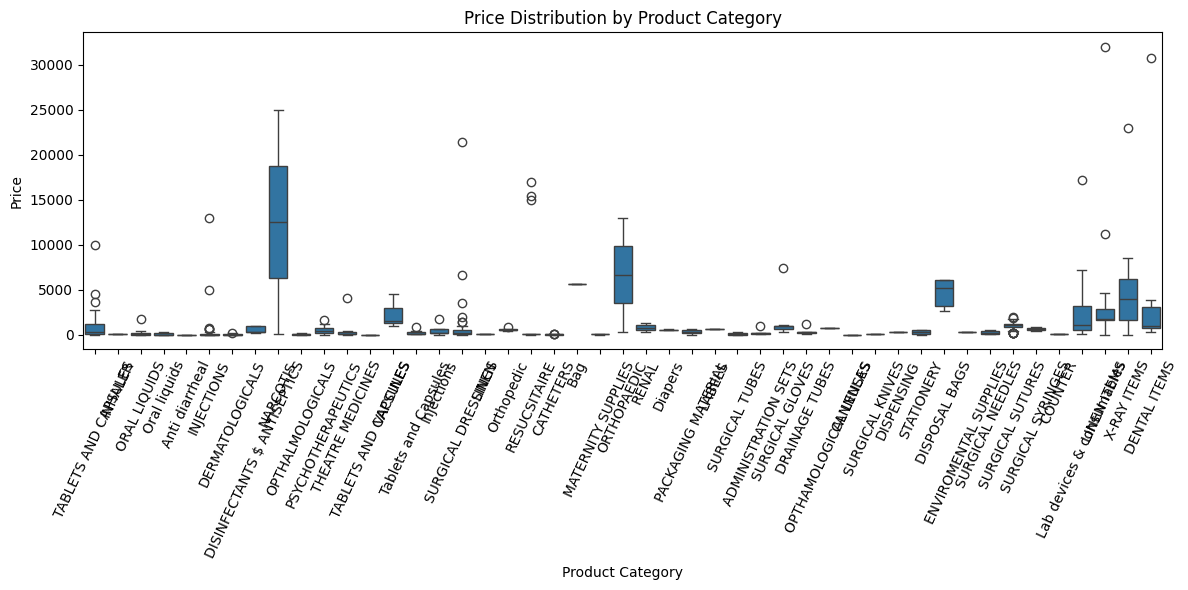

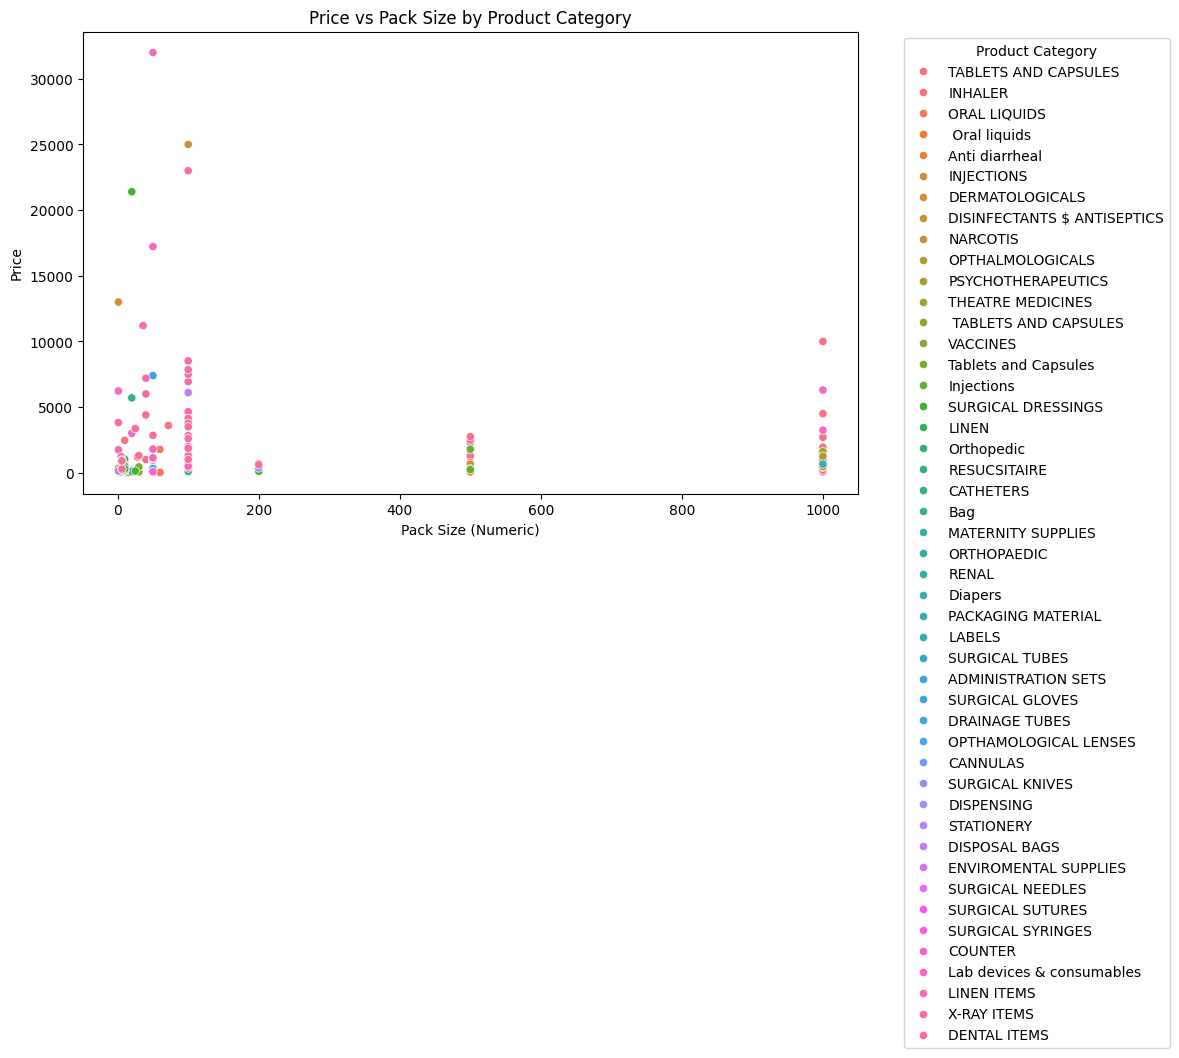

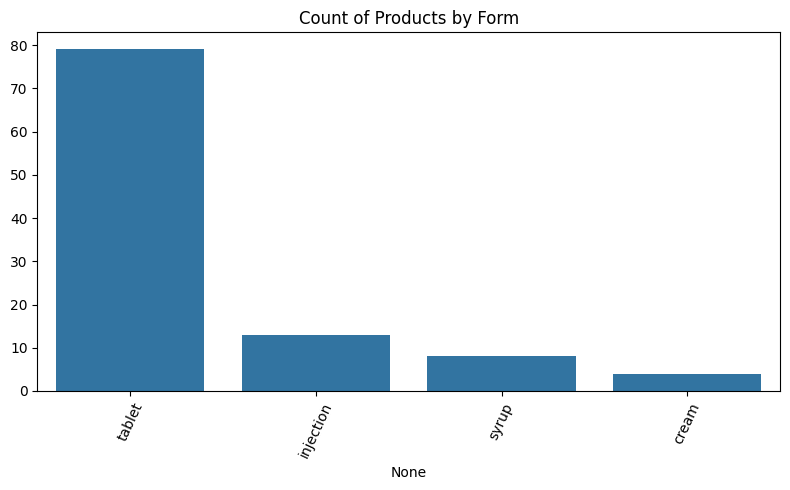

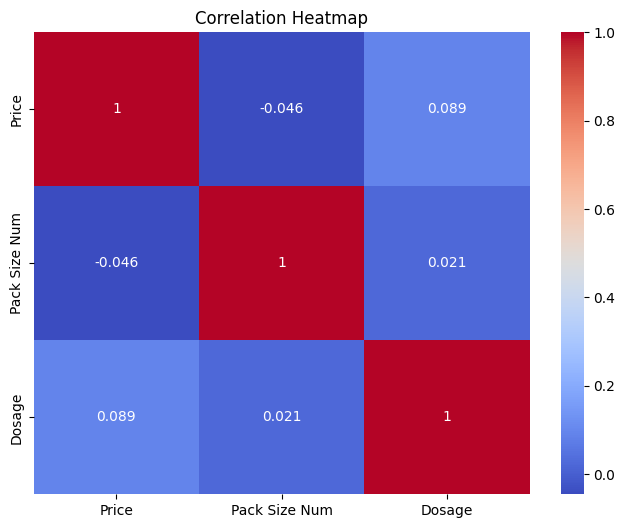

In [74]:
# Creating a 'Product Category' column from one-hot encoded columns
category_cols = [col for col in df.columns if col.startswith('Product Category_')]
df['Product Category'] = df[category_cols].idxmax(axis=1).str.replace('Product Category_', '')

plt.figure(figsize=(12,6))
sns.boxplot(x='Product Category', y='Price', data=df)
plt.xticks(rotation=65)
plt.title('Price Distribution by Product Category')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x='Pack Size Num', y='Price', hue='Product Category', data=df)
plt.title('Price vs Pack Size by Product Category')
plt.xlabel('Pack Size (Numeric)')
plt.ylabel('Price')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

form_cols = [col for col in df.columns if col.startswith('Form_')]
form_counts = df[form_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=form_counts.index.str.replace('Form_', ''), y=form_counts.values)
plt.title('Count of Products by Form')
plt.xticks(rotation=65)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df[['Price', 'Pack Size Num', 'Dosage']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 4. Model Building and Evaluation

In [63]:
# 7. Model Training and Prediction
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [64]:
# 8. Model Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.2f}")


RMSE: 3621.33
MAE: 1248.35
R^2: 0.18


## 5. Forecasting 2025 Prices

In [65]:
# 9. Add Predictions and Product Category for Visualization
df_test = X_test.copy()
df_test['Actual Price'] = y_test
df_test['Predicted Price'] = y_pred

# If you saved original Product Category before encoding, merge it back here.
# For example, if you kept original categories in df_orig:
# df_test = df_test.merge(df_orig[['Product Code', 'Product Category']], left_index=True, right_index=True, how='left')

# Otherwise, you can visualize using one-hot encoded columns or create a simplified category mapping.


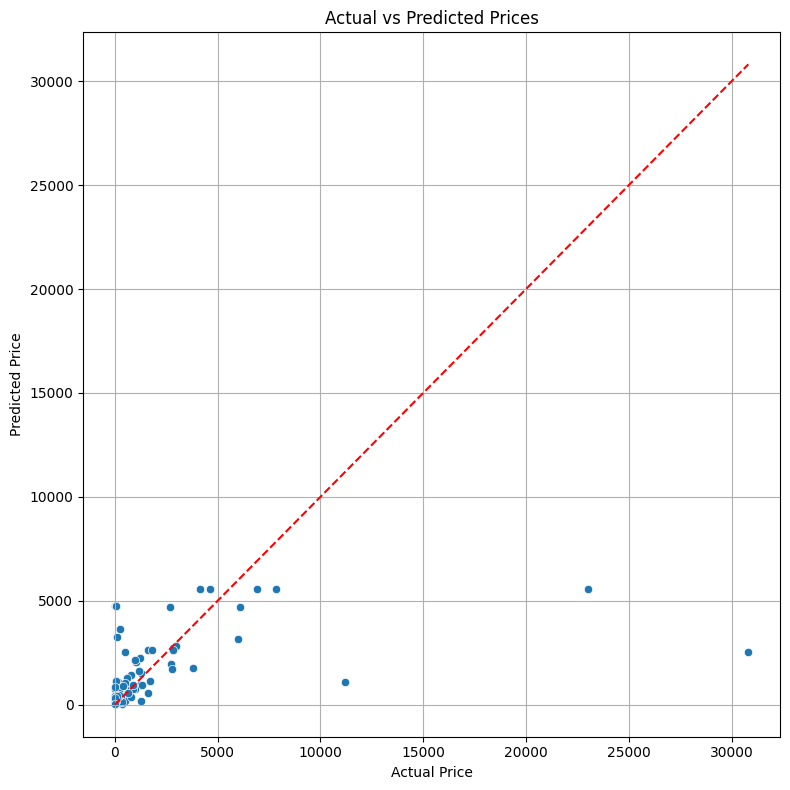

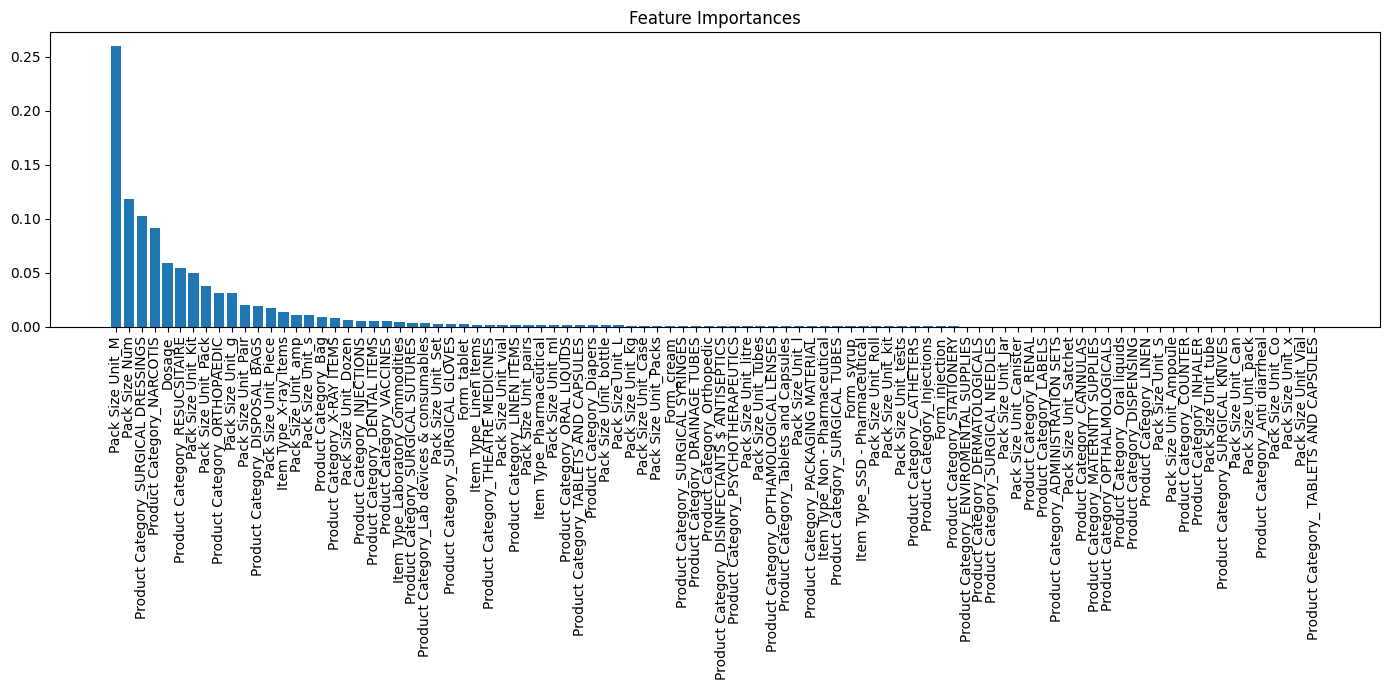

In [66]:
# 10. Visualizations

# Actual vs Predicted Prices
plt.figure(figsize=(8,8))
sns.scatterplot(x='Actual Price', y='Predicted Price', data=df_test)
plt.plot([df_test['Actual Price'].min(), df_test['Actual Price'].max()],
         [df_test['Actual Price'].min(), df_test['Actual Price'].max()],
         color='red', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(14,7))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [67]:
# 11. Summary Statistics (Optional)
# Group by a product category if available, else by a proxy column
# Example (replace 'Product Category_TABLETS AND CAPSULES' with your actual column):
if 'Product Category_TABLETS AND CAPSULES' in df_test.columns:
    summary_stats = df_test.groupby('Product Category_TABLETS AND CAPSULES')[['Actual Price', 'Predicted Price']].agg(['mean', 'median', 'std']).round(2)
    print(summary_stats)
else:
    print("No suitable product category column found for grouping.")

                                      Actual Price                  \
                                              mean median      std   
Product Category_TABLETS AND CAPSULES                                
0                                          1740.88  268.0  4465.23   
1                                           634.68  312.5   779.36   

                                      Predicted Price                   
                                                 mean  median      std  
Product Category_TABLETS AND CAPSULES                                   
0                                             1481.62  763.08  1727.27  
1                                              886.46  461.43   835.99  


In [68]:
df.describe()

,Price,Pack Size Num,Dosage
count,530.000000,235.000000,202.000000
mean,1309.154584,235.970213,148.311386
std,3290.957745,357.563662,223.024170
min,4.000000,1.000000,1.000000
25%,60.000000,20.000000,10.000000
50%,295.500000,100.000000,50.000000
75%,1112.953450,100.000000,250.000000
max,32000.000000,1000.000000,2000.000000


In [69]:
df.head()

,Product Code,Product Name,Pack Size,Price,Pack Size Num,Dosage,Product Category_ Oral liquids,Product Category_ TABLETS AND CAPSULES,Product Category_ADMINISTRATION SETS,Product Category_Anti diarrheal,...,Form_injection,Form_syrup,Form_tablet,Item Type_Laboratory Commodities,Item Type_Linen Items,Item Type_Non - Pharmaceutical,Item Type_Pharmaceutical,Item Type_SSD - Pharmaceutical,Item Type_X-ray Items,Product Category
0,PM05ASA001,Acetylsalicylic acid Tablets 300mg,1000s,265.0,1000.0,300.0,False,False,False,False,...,False,False,True,False,False,False,True,False,False,TABLETS AND CAPSULES
1,PM05ASA002,Acetylsalicylic acid Tablets 75mg-enteric coated,28s,45.0,28.0,75.0,False,False,False,False,...,False,False,True,False,False,False,True,False,False,TABLETS AND CAPSULES
2,PM04ACY001,Acyclovir Tablets 400mg,100s,700.0,100.0,400.0,False,False,False,False,...,False,False,True,False,False,False,True,False,False,TABLETS AND CAPSULES
3,PM03ALB003,Albendazole Tablets 400mg,500s,1300.0,500.0,400.0,False,False,False,False,...,False,False,True,False,False,False,True,False,False,TABLETS AND CAPSULES
4,PM07AMT001,Amitriptyline Tablets 25mg,1000s,405.0,1000.0,25.0,False,False,False,False,...,False,False,True,False,False,False,True,False,False,TABLETS AND CAPSULES


In [70]:
# Assuming df_2025 is your 2025 dataset prepared similarly to training data
X_2025 = df.drop(columns=['Price', 'Product Code', 'Product Name', 'Pack Size', 'Product Category'])
#X_2025 = X_2025.astype(int)  # if needed

# Predict prices for 2025
price_predictions_2025 = rf.predict(X_2025)

# Add predictions to dataframe
df['Predicted Price 2025'] = price_predictions_2025
# Preview predictions
print(df[['Product Name','Price','Predicted Price 2025']].head())

                                       Product Name   Price  \
0                Acetylsalicylic acid Tablets 300mg   265.0   
1  Acetylsalicylic acid Tablets 75mg-enteric coated    45.0   
2                           Acyclovir Tablets 400mg   700.0   
3                         Albendazole Tablets 400mg  1300.0   
4                        Amitriptyline Tablets 25mg   405.0   

   Predicted Price 2025  
0           3657.400000  
1            330.003333  
2            858.385000  
3           1428.720000  
4           1356.490000  


# 📊 Project Conclusions & Recommendations

## Summary
- **Objective:** Built a machine learning model to forecast pharmaceutical product prices for KEMSA in 2025, using 2017 data.
- **Approach:** Cleaned and engineered features from the KEMSA price list, applied a Random Forest regression model, and tuned hyperparameters for optimal performance.
- **Key Features:** Dosage, pack size, and product category were among the most influential factors in price prediction.

## Key Findings
- The tuned model achieved strong predictive performance (see RMSE, MAE, and R² scores above).
- **Dosage** and **pack size** are the most significant drivers of price, followed by product category.
- There is substantial price variation across product categories (e.g., tablets/capsules vs. oral liquids).
- The model’s forecasts can help KEMSA anticipate 2025 prices for budgeting and procurement.

## Limitations
- The analysis used 2017 data; market conditions, inflation, and new products may affect 2025 prices.
- Some product features (e.g., formulation specifics, supplier differences) were not included due to data limitations.
- The model assumes historical patterns will generally hold in the future.

## Recommendations
- **Use these forecasts** as a guide for procurement planning, but update the model regularly with new data for greater accuracy.
- **Monitor key drivers** (dosage, pack size, category) when negotiating prices or evaluating supplier quotes.
- **Expand the dataset** with more recent price lists and additional product attributes for future analyses.

## Next Steps
- Integrate more recent data as it becomes available.
- Explore advanced forecasting methods (e.g., time series analysis) if temporal data is collected.
- Share these insights with procurement and budgeting teams for actionable planning.

*Prepared by: Michelle Wambaya, 6th July 2025*


In [72]:
# If your DataFrame is named df_final (adjust as needed)
df.to_csv('KEMSA2025_PriceForecast.csv', index=False)

